In [22]:
# 0) Setup
from datasets import load_dataset
import pandas as pd
import pytz, re, math
from datetime import datetime, timedelta
from urllib.parse import urlsplit, urlunsplit, parse_qsl, urlencode
from sentence_transformers import SentenceTransformer
import numpy as np


In [23]:

IST = pytz.timezone("Asia/Kolkata")
model = SentenceTransformer("all-MiniLM-L6-v2")

# 1) Ingest
ds = load_dataset("zenml/llmops-database")["train"].to_pandas()
df = ds.copy()


In [24]:
# --- Setup ---
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
# --- Load dataset ---
# This pulls directly from Hugging Face Hub
dataset = load_dataset("zenml/llmops-database")

# Convert the 'train' split into pandas DataFrame
df = dataset["train"].to_pandas()

In [26]:
df.head(5)  # Display the first few rows of the DataFrame

,created_at,title,industry,year,source_url,company,application_tags,tools_tags,extra_tags,techniques_tags,short_summary,full_summary
0,2025-09-09T07:46:00.000Z,Natural Language Analytics Assistant Using Ama...,Media & Entertainment,2025.0,https://aws.amazon.com/blogs/machine-learning/...,skai,"data_analysis,question_answering,chatbot,data_...","monitoring,api_gateway,orchestration,scaling,s...","amazon bedrock agents,natural language process...","rag,prompt_engineering,multi_agent_systems,age...","Skai, an omnichannel advertising platform, dev...",# Skai: Natural Language Analytics Assistant U...
1,2025-09-09T07:42:00.000Z,AI-Powered Hyper-Personalized Email Campaign A...,Tech,2025.0,https://blog.promptlayer.com/ai-sales-engineer...,promptlayer,"customer_support,content_moderation,classifica...","fastapi,open_source,documentation,monitoring","prompt engineering,ai agents,email automation,...","prompt_engineering,multi_agent_systems,agent_b...",PromptLayer built an automated AI sales system...,# PromptLayer: AI-Powered Hyper-Personalized E...
2,2025-09-09T07:39:00.000Z,Claude Code Agent Architecture: Single-Threade...,Tech,2025.0,https://blog.promptlayer.com/claude-code-behin...,anthropic,"code_generation,code_interpretation","docker,monitoring,security,guardrails,reliabil...","agent architecture,single threaded loop,tool o...","prompt_engineering,multi_agent_systems,agent_b...",Anthropic's Claude Code implements a productio...,# Anthropic: Claude Code Agent Architecture: S...
3,2025-09-08T09:00:00.000Z,Dynamic Prompt Injection for Reliable AI Agent...,Tech,2025.0,https://www.controlpla.in/blog/prompt-injectio...,control_plain,"customer_support,chatbot","reliability,compliance,guardrails","prompt engineering,ai agents,production deploy...","prompt_engineering,few_shot,semantic_search,ag...",Control Plain addressed the challenge of unrel...,# Control Plain: Dynamic Prompt Injection for ...
4,2025-09-08T08:14:00.000Z,Enterprise RAG System with Coveo Passage Retri...,Tech,2025.0,https://aws.amazon.com/blogs/machine-learning/...,coveo,"question_answering,document_processing,custome...","serverless,api_gateway,monitoring,databases,se...","rag,retrieval augmented generation,amazon bedr...","rag,embeddings,semantic_search,vector_search,p...",Coveo addresses the challenge of LLM accuracy ...,# Coveo: Enterprise RAG System with Coveo Pass...


In [27]:
# --- Quick look at data ---
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())


Shape: (907, 12)

Columns: ['created_at', 'title', 'industry', 'year', 'source_url', 'company', 'application_tags', 'tools_tags', 'extra_tags', 'techniques_tags', 'short_summary', 'full_summary']


In [28]:

# --- Basic info ---
print("\nData types:")
print(df.dtypes)



Data types:
created_at           object
title                object
industry             object
year                float64
source_url           object
company              object
application_tags     object
tools_tags           object
extra_tags           object
techniques_tags      object
short_summary        object
full_summary         object
dtype: object


In [29]:

print("\nMissing values:")
print(df.isna().sum())



Missing values:
created_at           0
title                0
industry             0
year                95
source_url           1
company              0
application_tags     0
tools_tags           0
extra_tags           0
techniques_tags      0
short_summary        0
full_summary         0
dtype: int64


/var/folders/qw/kndrzd253bbb5qrt4cz3wxqr0000gn/T/ipykernel_95284/3093001556.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_week"] = df["created_at"].dt.to_period("W")


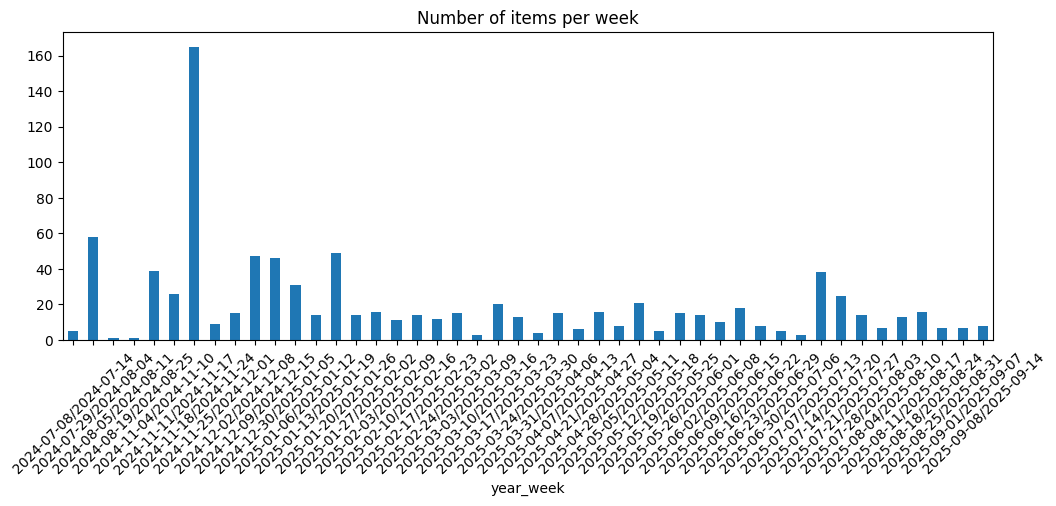

In [30]:

# --- Created_at field analysis ---
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["year_week"] = df["created_at"].dt.to_period("W")

# Count by month
monthly_counts = df["year_week"].value_counts().sort_index()
monthly_counts.plot(kind="bar", figsize=(12,4))
plt.title("Number of items per week")
plt.xticks(rotation=45)
plt.show()


In [31]:
# --- Check for duplicates ---
print("\nShape before removing duplicates:", df.shape)
# By title
dup_titles = df[df.duplicated("title", keep=False)].sort_values(["title", "created_at"])
print("Number of duplicate titles:", dup_titles["title"].nunique())
# print("Sample duplicate titles:\n", dup_titles[["title", "created_at", "source_url"]].head(10))

# By source_url
dup_urls = df[df.duplicated("source_url", keep=False)].sort_values(["source_url", "created_at"])
print("Number of duplicate URLs:", dup_urls["source_url"].nunique())
# print("Sample duplicate URLs:\n", dup_urls[["title", "created_at", "source_url"]].head(10))

# --- Remove duplicates ---
df = df.sort_values("created_at").drop_duplicates(subset=["title"], keep="last")
df = df.sort_values("created_at").drop_duplicates(subset=["source_url"], keep="last")

print("\nShape after removing duplicates:", df.shape)


Shape before removing duplicates: (907, 13)
Number of duplicate titles: 2
Number of duplicate URLs: 10

Shape after removing duplicates: (896, 13)


In [32]:
df["industry"].value_counts()

industry
Tech                     480
Finance                   82
E-commerce                79
Healthcare                58
Media & Entertainment     47
Insurance                 20
Other                     19
Education                 16
Automotive                16
Consulting                15
Government                14
Telecommunications        13
Legal                     13
Energy                     8
Research & Academia        8
HR                         7
                           1
Name: count, dtype: int64

In [33]:
industries_of_interest = ["Tech", "Telecommunications", "Research & Academia"]

In [34]:
filtered_df = df[df["industry"].isin(industries_of_interest)]
filtered_df.shape
filtered_df.head()  # Display the first few rows of the filtered dataframe

,created_at,title,industry,year,source_url,company,application_tags,tools_tags,extra_tags,techniques_tags,short_summary,full_summary,year_week
906,2024-07-10 14:21:00+00:00,LLM Validation and Testing at Scale: GitLab's ...,Tech,2024.0,https://about.gitlab.com/blog/2024/05/09/devel...,gitlab,"code_generation,high_stakes_application,regula...","monitoring,cicd,devops,continuous_deployment,c...","llm,testing,evaluation,prompt engineering,metr...","prompt_engineering,error_handling,latency_opti...",GitLab developed a robust framework for valida...,# Gitlab: LLM Validation and Testing at Scale:...,2024-07-08/2024-07-14
904,2024-07-10 14:21:00+00:00,Building a Scalable Retriever-Ranker Architect...,Tech,2024.0,https://blog.malt.engineering/super-powering-o...,malt,"structured_output,realtime_application","kubernetes,monitoring,scaling,devops,orchestra...","recommenders,rerankers,vector database,qdrant,...","embeddings,semantic_search,vector_search,model...",Malt's implementation of a retriever-ranker ar...,# Malt: Building a Scalable Retriever-Ranker A...,2024-07-08/2024-07-14
903,2024-07-10 14:38:00+00:00,Building Secure and Private Enterprise LLM Inf...,Tech,2024.0,https://slack.engineering/how-we-built-slack-a...,slack,"regulatory_compliance,legacy_system_integration","security,compliance,guardrails,reliability,sca...","rag,aws,sagemaker,security,privacy,compliance,...","rag,semantic_search,error_handling,latency_opt...",Slack implemented AI features by developing a ...,# Slack: Building Secure and Private Enterpris...,2024-07-08/2024-07-14
902,2024-07-10 14:39:00+00:00,Building and Scaling LLM Applications at Discord,Tech,2024.0,https://discord.com/blog/developing-rapidly-wi...,discord,"chatbot,content_moderation,structured_output,r...","monitoring,scaling,devops,security,compliance,...","prompt engineering,evaluation,deployment,safet...","prompt_engineering,fine_tuning,model_optimizat...",Discord shares their comprehensive approach to...,# Discord: Building and Scaling LLM Applicatio...,2024-07-08/2024-07-14
901,2024-07-31 13:30:00+00:00,Optimizing Text-to-SQL Pipeline Using Agent Ex...,Tech,2024.0,https://idinsight.github.io/tech-blog/blog/aam...,idinsight,"question_answering,data_analysis","fastapi,crewai,databases,scalability,reliability","text to sql,llm,crewai,fastapi,rag,prompt engi...","rag,prompt_engineering,multi_agent_systems,mod...",Ask-a-Metric developed a WhatsApp-based AI dat...,# IDInsight: Optimizing Text-to-SQL Pipeline U...,2024-07-29/2024-08-04


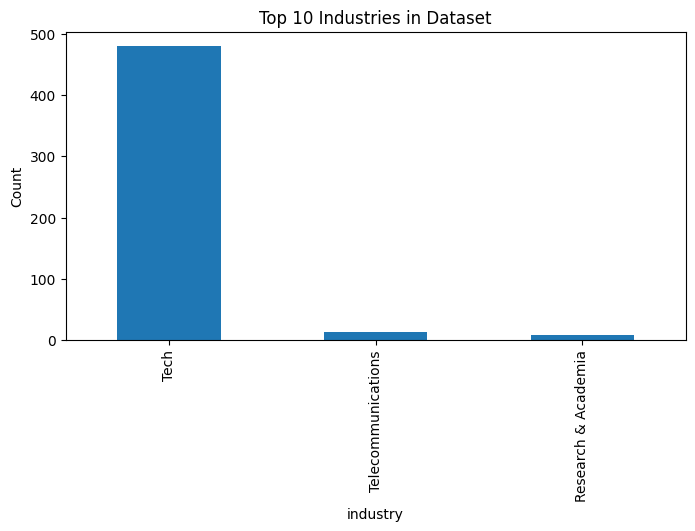

In [35]:

# --- Top industries ---
plt.figure(figsize=(8,4))
filtered_df["industry"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Industries in Dataset")
plt.ylabel("Count")
plt.show()


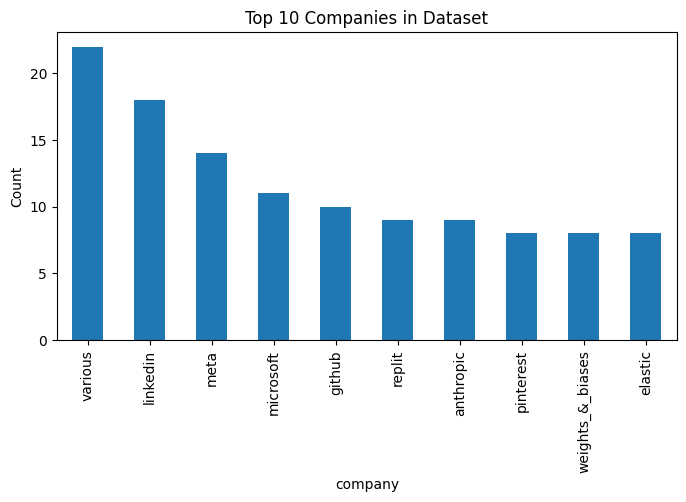

In [36]:

# --- Top companies mentioned ---
plt.figure(figsize=(8,4))
filtered_df["company"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Companies in Dataset")
plt.ylabel("Count")
plt.show()


In [37]:
# save the dataframe to a csv file
filtered_df.to_csv("filtered_llmops_database.csv", index=False)
